### **Specify max. $\tau$.**

In [737]:
import numpy as np
import ot

#### Stochastic transition matrix for transitions. Exemplified for iid below but applies to every stochastic matrix.

In [2]:
# define time steps
T = 100
T

100

In [3]:
# define transition matrix over states
W = np.array([[0.2, 0.1, 0], [0.8, 0, 0.4], [0, 0.9, 0.6]])
W

array([[0.2, 0.1, 0. ],
       [0.8, 0. , 0.4],
       [0. , 0.9, 0.6]])

In [4]:
W.shape

(3, 3)

#### Adjacency matrix for DFA transitions.

In [44]:
# put -1 if no transition, 1 and 0 are symbols
A = np.array([ [0, 1, -1], [1, -1, 1], [-1, 0, 0] ])
A

array([[ 0,  1, -1],
       [ 1, -1,  1],
       [-1,  0,  0]])

### ****Count number of strings, generate strings

In [45]:
def count_num_str(n):
    return 2**n

num_str = count_num_str(tau)
num_str

4

In [46]:
def generateStrings(symbols, t):
    strings = []
    n = len(symbols)
    generateStringsRec(symbols, "", n, t, strings)
    return strings
    
def generateStringsRec(symbols, prefix, n, t, strings):
     
    # Base case: t is 0,
    # print prefix
    if (t == 0) :
        strings.append(prefix)
        return
 
    # One by one add all characters
    # from set and recursively
    # call for k equals to k-1
    for i in range(n):
 
        # Next character of input added
        newPrefix = prefix + symbols[i]
         
        # k is decreased, because
        # we have added a new character
        generateStringsRec(symbols, newPrefix, n, t - 1, strings)

In [47]:
symbols = ['0', '1']
idx_state_dict = {0: 'q0', 1: 'q1', 2: 'q2', 3: 'q3'}
state_idx_dict = {'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3}

See generated strings. (uncomment print)

In [48]:
def generateAllStrings(symbols, t):
    strings = []
#     for t in range(t,t+1):
    strings.extend(generateStrings(symbols, t))      
    return strings

strings = generateAllStrings(symbols, tau)
# print(strings)

#### Provide tuple of generated strings, induced DFA trajectories, path probabilities in the forward dynamics. 

In [49]:
# path probability induced by the transition rate matrix and the adjacency matrix

def get_path_prob(W, A, strings):
    path_with_prob = []
    for string in strings:
        string_prob, path = compute_prob(W, A, string)
        # normalizing the probability below
        normalized_string_prob = string_prob*(2**len(string))/num_str
        path_with_prob.append((string, normalized_string_prob , path))
        
    return path_with_prob
    
def compute_prob(W, A, string):
    curr_state = 0
    string_prob = 1
    path = []
    for symbol in string:
        path.append(idx_state_dict[curr_state])
        next_state = do_transition(A, curr_state, symbol)
      #  print(symbol)
      #  print("---")
      #  print(curr_state)
        transition_prob = get_transition_prob(curr_state, next_state, W)
        string_prob *= transition_prob
        curr_state = next_state
    path.append(idx_state_dict[next_state])
    
    return string_prob, path

# encodes adjacency matrix
    
def do_transition(A, curr_state, symbol):
    for j in range(len(A[:, curr_state])):
        if A[j][curr_state] == int(symbol):
            return j

        # with transition rates
        
def get_transition_prob(curr_state, next_state, W):
   # print(curr_state)
   # print("---")
   # print(next_state)
    return W[next_state][curr_state]

# compute path probabilities
path_prob = get_path_prob(W, A, strings)
path_prob

[('00', 0.81, ['q0', 'q0', 'q0']),
 ('01', 0.09000000000000001, ['q0', 'q0', 'q1']),
 ('10', 0.09000000000000001, ['q0', 'q1', 'q2']),
 ('11', 0.010000000000000002, ['q0', 'q1', 'q0'])]

#### Compute inflow for each DFA state.

In [50]:
# Cell to calculate inflow vector
def calculate_inflow_vector(W):
    return np.sum(W, axis=1)
  
inflow_vector = calculate_inflow_vector(W)
inflow_vector

array([1. , 0.2, 1.8])

In [51]:
# Verify normalization
def verify_normalization(path_prob):
    return [prob[1] for prob in path_prob]

x = verify_normalization(path_prob)
s = 0
for i in x:
    s += i
# s

#### Prepare adjoint (auxiliary) dynamics matrix

In [52]:
def calculate_aux_matrix(W, inflow_vector):
    return np.transpose([W[i]/inflow_vector[i] for i in range(W.shape[0])])

W_aux = calculate_aux_matrix(W, inflow_vector)
W_aux

array([[0.9, 0.5, 0. ],
       [0.1, 0. , 0.5],
       [0. , 0.5, 0.5]])

In [53]:
# calculate prob of sequence in the W_aux matrix
w_aux_path_prob = get_path_prob(W_aux, A, strings)
# path_prob

### Give path probability tuple augmented with accumulated inflow $\epsilon_{\tau}$ associated with each forward path in the forward dynamics.

### Uncomment the if statement below for the stopping condition. Here it applies to stopping by accepting but this command is easily modified to “any” stopping condition

In [54]:
def append_epsilon_to_path_prob(path_prob, inflow_vector):
    appended_path_prob = []
    for path in path_prob:
        dfa_states = path[2]
        epsilon = 1.0
        for i in range(len(dfa_states)):
            #if dfa_states[i] == 'q0' and i > 0: break
            if i == len(dfa_states)-1: continue
            index = list(idx_state_dict.keys())[list(idx_state_dict.values()).index(dfa_states[i])]
            inflow_prob = inflow_vector[index]
            epsilon *= inflow_prob
        path = path + (np.log(epsilon),)
        appended_path_prob.append(path)
    return appended_path_prob

In [55]:
appended_path_prob = append_epsilon_to_path_prob(path_prob, inflow_vector)
appended_path_prob

[('00', 0.81, ['q0', 'q0', 'q0'], 0.0),
 ('01', 0.09000000000000001, ['q0', 'q0', 'q1'], 0.0),
 ('10', 0.09000000000000001, ['q0', 'q1', 'q2'], -1.6094379124341003),
 ('11', 0.010000000000000002, ['q0', 'q1', 'q0'], -1.6094379124341003)]

### Get reverse trajectory probability by revseqstates in auxiliary dynamics.

In [56]:
def get_path_prob2(W, state_sequence):
    prob = 1.0
    for i in range(len(state_sequence)-1):
        prob *= W[state_idx_dict[state_sequence[i+1]]][state_idx_dict[state_sequence[i]]]
    return prob

path_prob_2 = []
for path in appended_path_prob:
    string = path[0]
    seqStates = path[2]
    stoppedSeqStates = []
    for i in range(len(seqStates)):
        stoppedSeqStates.append(seqStates[i])
        #if i > 0 and seqStates[i] == 'q0':
           # break
    revSeqStates = list(reversed(stoppedSeqStates))
    prob_stopped_seq_states = get_path_prob2(W, stoppedSeqStates)
    prob_reverse_seq_states = get_path_prob2(W, revSeqStates)
    ratio = prob_stopped_seq_states / prob_reverse_seq_states
    path = path + (np.log(ratio),)
    path_prob_2.append(path)
    
# path_prob_2

Computing bound on Wasserstein Distance

In [195]:
import numpy as np
import random
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import ot

In [2]:
def generate_cost_matrix(N):
    M = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                M[i][j] = 1.0
    return M

In [546]:
# define transition matrix over states
W = np.array([[0.2, 0.1, 0], [0.8, 0, 0.4], [0, 0.9, 0.6]])

N = 10
# W = generate_transition_matrix(N)

W = [[.1, .1, 0, 0, 0, 0, 0, 0, 0, 0],
    [.9, 0, .1, 0, 0, 0, 0, 0, 0, 0],
    [0, .9, 0, .1, 0, 0, 0, 0, 0, 0],
    [0, 0, .9, 0, .1, 0, 0, 0, 0, 0],
    [0, 0, 0, .9, 0, .1, 0, 0, 0, 0],
    [0, 0, 0, 0, .9, 0, .1, 0, 0, 0],
    [0, 0, 0, 0, 0, .9, 0, .1, 0, 0],
    [0, 0, 0, 0, 0, 0, .9, 0, .1, 0],
    [0, 0, 0, 0, 0, 0, 0, .9, 0, .1],
    [0, 0, 0, 0, 0, 0, 0, 0, .9, .1]]

# number of states
N = len(W)

# time steps
T = 10000

In [547]:
print("W = \n", W)
print("N = ", N)
print("T = ", T)

W = 
 [[0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0], [0.9, 0, 0.1, 0, 0, 0, 0, 0, 0, 0], [0, 0.9, 0, 0.1, 0, 0, 0, 0, 0, 0], [0, 0, 0.9, 0, 0.1, 0, 0, 0, 0, 0], [0, 0, 0, 0.9, 0, 0.1, 0, 0, 0, 0], [0, 0, 0, 0, 0.9, 0, 0.1, 0, 0, 0], [0, 0, 0, 0, 0, 0.9, 0, 0.1, 0, 0], [0, 0, 0, 0, 0, 0, 0.9, 0, 0.1, 0], [0, 0, 0, 0, 0, 0, 0, 0.9, 0, 0.1], [0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1]]
N =  10
T =  10000


In [817]:
# define initial probability distribution
generate_cost_matrix(5)

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [204]:
def get_velocity_at_time(W, p_prev):    
    rows = len(W)
    cols = len(W[0])
    
    velocity = 0
    
    for m in range(cols):
        for n in range(m,rows):
#             val = abs(W[n][m]*p_prev[m] - W[m][n]*p_prev[n])
            val = W[n][m]*p_prev[m]
            velocity += val
            
    return velocity

In [372]:
x = [[.05 for j in range(21)] for i in range(21)]
for i in range(21):
    x[i][i] = 0
x = np.array(x)
y = [1/21]*21
v = get_velocity_at_time(x,y)
print(v)

0.999999999999997


In [4]:
def simulate_DTMC(W, time, p_start):
    
    p_distr_over_time = {}
    p_distr_over_time[0] = p_start
    
    N = len(W)
    bins = list(range(N))

    avg_velocity_over_time = [1]*time
    prev_velocity_avg = 0.0

    wasserstein_dist_over_time = [0]*time
    
    M = generate_cost_matrix(N)

    for t in range(1,time):
        p_prev = p_distr_over_time[t-1]

        p_distr_over_time[t] = np.matmul(W, p_prev)

        prev_velocity_avg = avg_velocity_over_time[t-1]
        curr_velocity = get_velocity_at_time(W, p_prev)
#         print("P Prev : ", p_prev)
#         print("Time : ", t)
#         print("Current Velocity : ", curr_velocity)
                
        new_velocity_avg = (prev_velocity_avg*(t-1) + curr_velocity)/t
        avg_velocity_over_time[t] = new_velocity_avg

#         wasserstein_dist_over_time[t] = (wasserstein_distance(bins, bins, p_start, p_distr_over_time[t]))
        
#         wasserstein_dist_over_time[t] = (wasserstein_distance(p_start, p_distr_over_time[t]))
        wasserstein_dist_over_time[t] = ot.emd2(p_start, p_distr_over_time[t], M)
    
#         print("Wass Dist at iteration : ", t, " : ", wasserstein_dist_over_time[t])
#         print("Avg Velocity at time : ", t, " : ", avg_velocity_over_time[t])
#         print("Ratio at time : ", t, " : ", wasserstein_dist_over_time[t] / avg_velocity_over_time[t])
#         print("------------")
    
    return p_distr_over_time, wasserstein_dist_over_time, avg_velocity_over_time

In [89]:
# UNUSED : Only to try out different graphs

def get_full_connected_graph(N):
    A = np.ones(shape=(N,N))
    for i in range(N):
        A[i][i] = 0
    W = A/A.sum(axis=1)
    p_start = [0]*N
    p_start[0] = 1
    return W, p_start

def get_full_connected_dag(N):
    W = np.zeros(shape=(N,N))
    for i in range(N-1):
        val = 1/(N-i-1)
        for j in range(i+1,N):
            W[j][i] = val
    W[N-1][N-1] = 1
    p_start = [0]*N
    p_start[0] = 1
    return W, p_start

def get_graph_with_no_absorbing_state(N):
    W = np.zeros(shape=(N,N))
    for i in range(N-1):
        val = 1/(N-i-1)
        for j in range(i+1,N):
            W[j][i] = val
    W[0][N-1] = 1
    p_start = [0]*N
    p_start[0] = 1
    return W, p_start

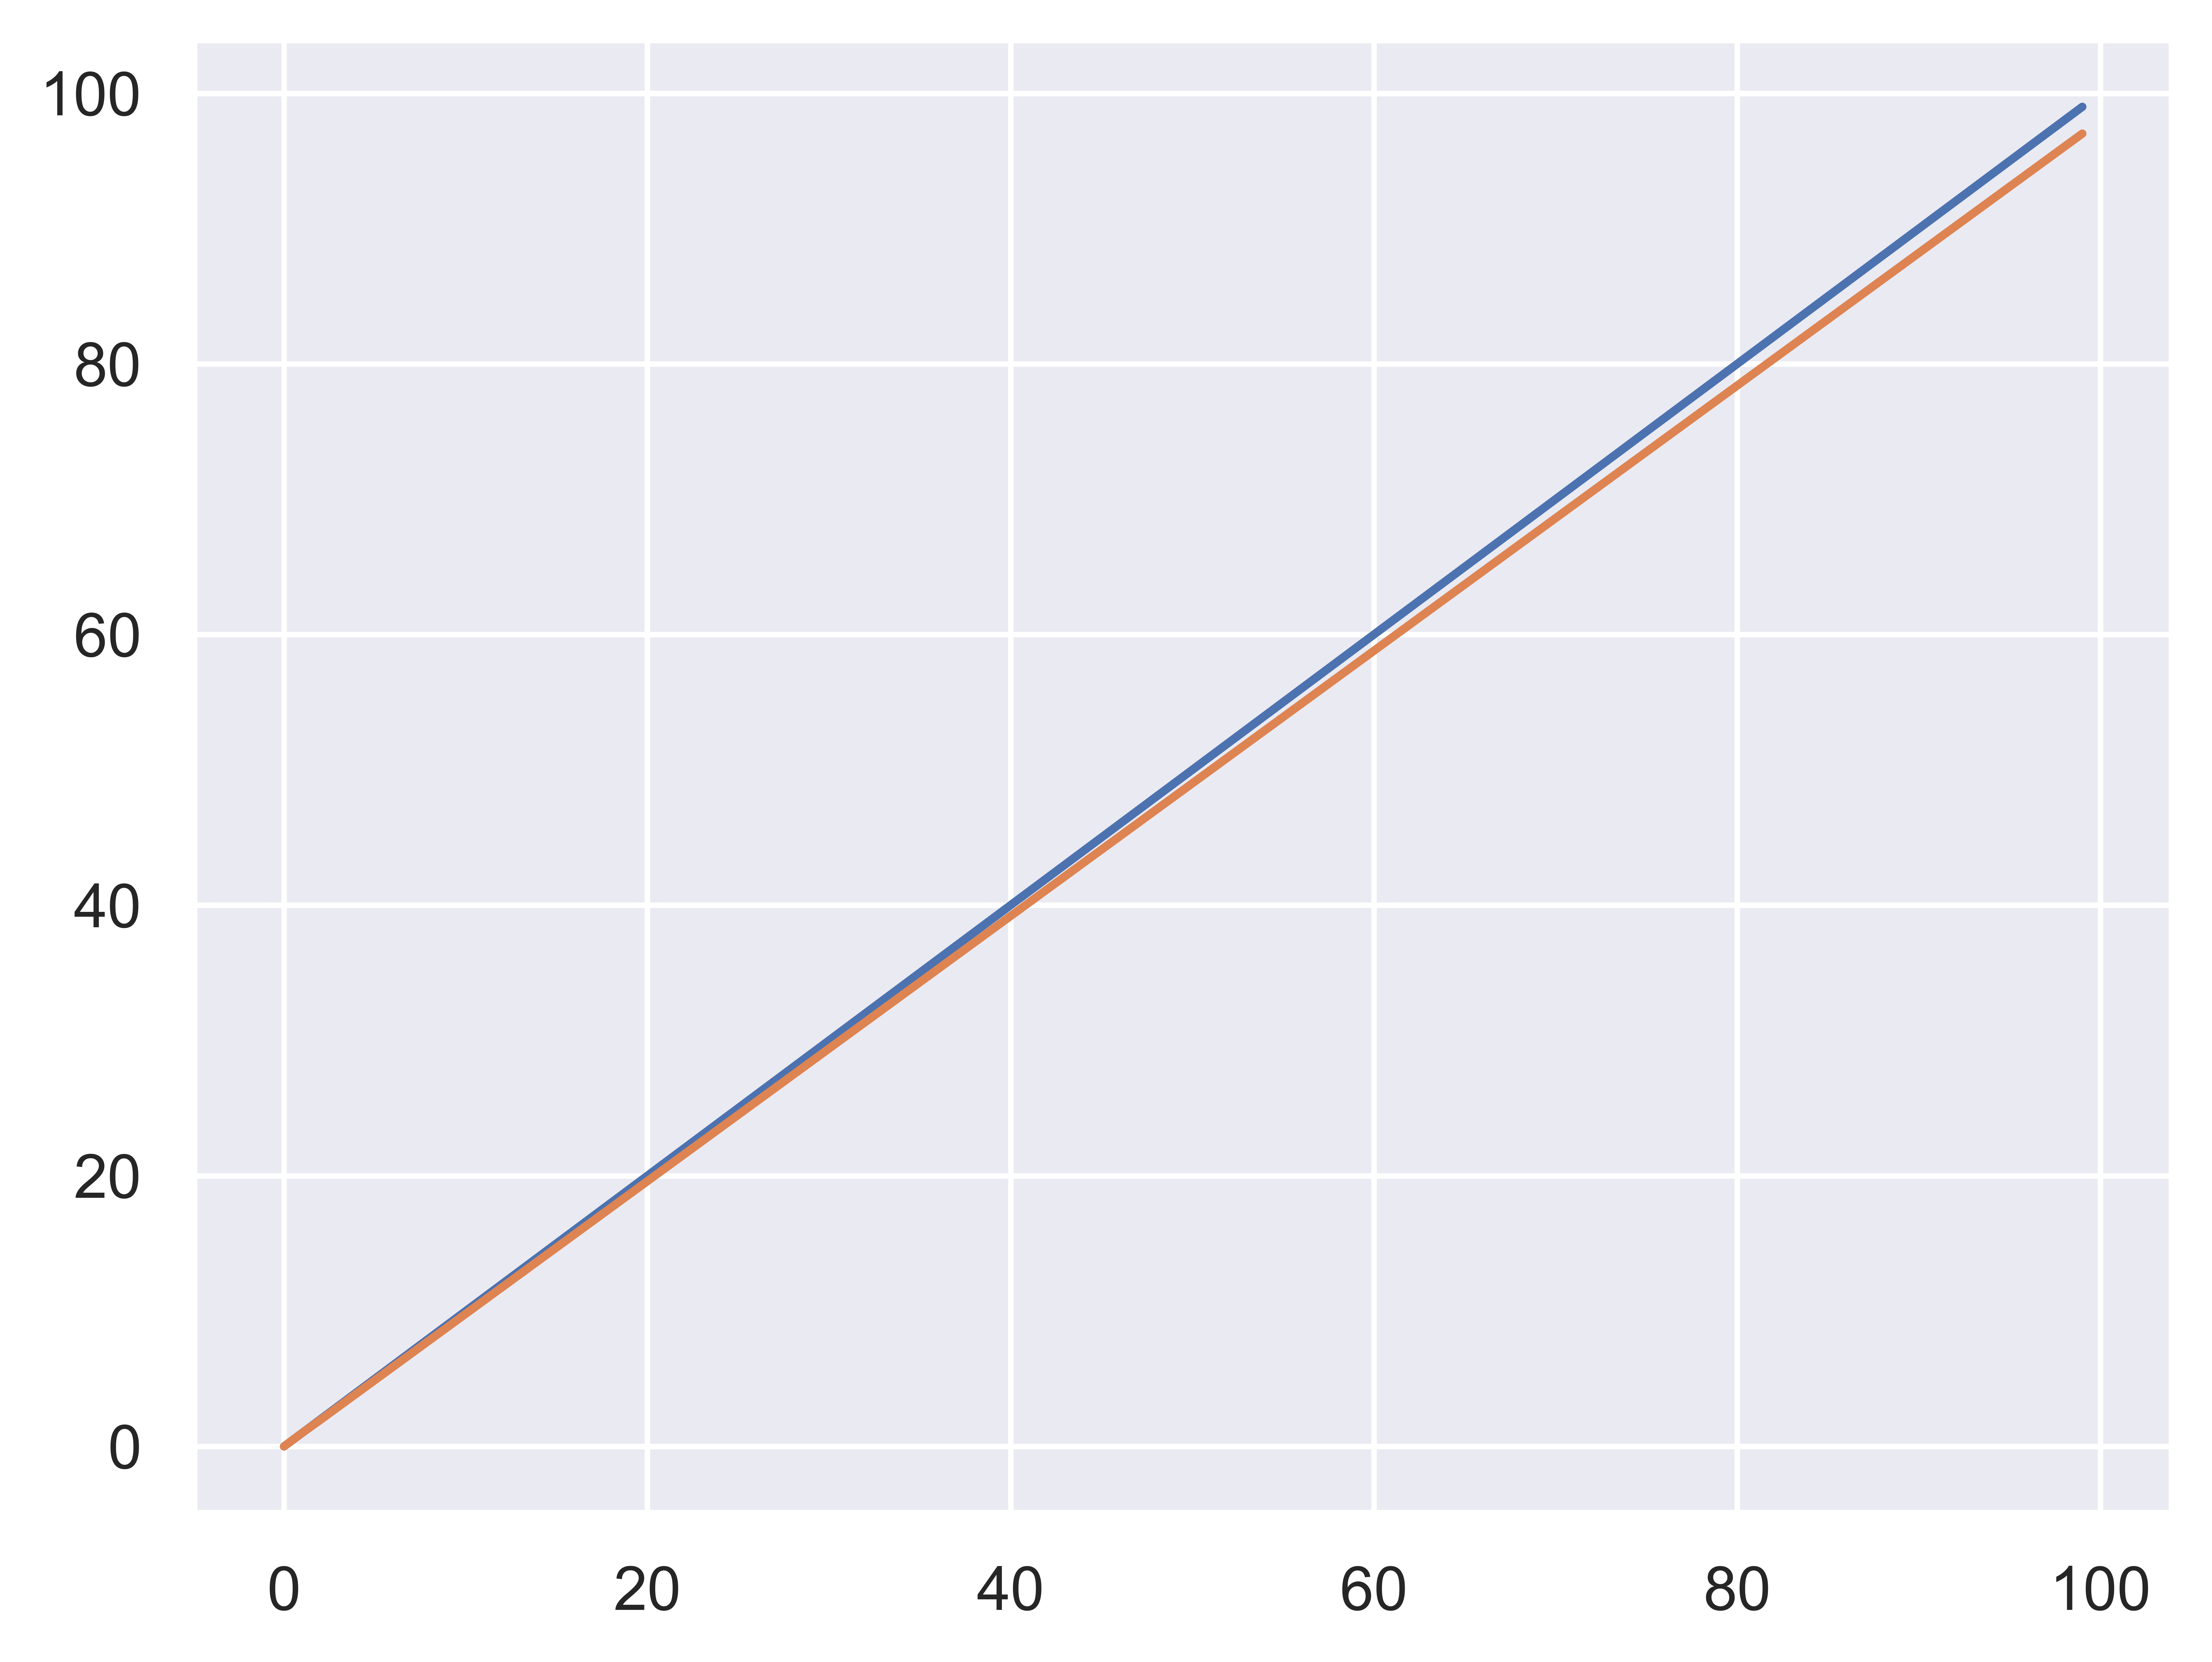


KeyboardInterrupt



In [196]:
for node_size in range(100,105):
    W, p_start = get_full_connected_graph(node_size)
    # W, p_start = get_full_connected_dag(5)

    # W, p_start = get_graph_with_no_absorbing_state(3)
    time = 100
    p_distr_over_time, wasserstein_dist_over_time, avg_velocity_over_time = simulate_DTMC(W, time, p_start)

    # verify the bound
    bound = [i / j for i, j in zip(wasserstein_dist_over_time, avg_velocity_over_time)]

    time_range = list(range(time))
    plt.plot(time_range)
    plt.plot(bound)
    plt.show()

In [90]:
# Plot the graph
# verify the bound
def plot(bound, T):    
    time_range = list(range(time))
    plt.plot(time_range)
    plt.plot(bound)
    plt.show()

Graph Simulations

In [7]:
def create_graph():
    return np.array(
    [
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

In [24]:
# create transition matrix
def create_transition_matrix(A_new):
    return (A_new.transpose() / A_new.sum(axis=1)).transpose()

In [23]:
def make_edges_bi_directional(A):
    N = len(A)
    for i in range(N):
        for j in range(N):
            if A[i][j] == 1:
                A[j][i] = 1

In [25]:
# add directed edges randomly and update transition matrix
def sample_new_neighbours(A, node, number_of_nbrs):
    not_connected_nodes = [idx for idx, nbr in enumerate(A[node]) if nbr != 1 and idx != node and A[idx][node] != 1]
    if len(not_connected_nodes) >= number_of_nbrs:
        return random.sample(not_connected_nodes, number_of_nbrs)
    return not_connected_nodes

def add_edges(A, node, number_of_edges, bi_directional=False):
    new_nbrs_list = sample_new_neighbours(A, node, number_of_edges)
    
    # update A
    for nbrs in new_nbrs_list:
        A[node][nbrs] = 1
        if bi_directional == True:
            A[nbrs][node] = 1
    return A

In [219]:
A = create_graph()

# make edges bidirectional
make_edges_bi_directional(A)

# visualize(A, node_pos)

# Add edges randomly
number_of_edges_list = [10]
# number_of_edges_list = [0]

time = 30
start_node = 0
curr_node = start_node
N = len(A)
p_start = [0]*N
p_start[0] = 1

number_of_edges_added = 0
bounds = {}

for number_of_edges in number_of_edges_list:
    A_new = add_edges(A, curr_node, number_of_edges, bi_directional=True)
    visualize(A_new, node_pos)
    T_new = create_transition_matrix(A_new)
    
#     p_distr_over_time, wasserstein_dist_over_time, avg_velocity_over_time = simulate_DTMC(T_new.transpose(), time+1, p_start)
    
#     curr_node = (curr_node + 1)%N
    
#     # calculate the bound
#     number_of_edges_added += number_of_edges
#     bound = [i / j for i, j in zip(wasserstein_dist_over_time, avg_velocity_over_time)]
#     bounds[number_of_edges_added] = bound

#     plot(bound, time)

# visualize_bounds(bounds, time)

In [155]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

In [193]:
def visualize_bounds(bounds, time):
    for key, value in bounds.items():
        plt.plot(value, label=str(key)+" edges")
    
    plt.plot(list(range(0, time+1)), label="N")
    plt.xlabel('Time')
    plt.ylabel('Bound')
    plt.legend()
    plt.show()

In [157]:
def create_df(bounds):
    flat_array = []
    for key, value in bounds.items():
        for idx, item in enumerate(value):
            flat_array.append([key, idx, item])
            
    return pd.DataFrame(data = np.array(flat_array),
#                   index = index_values, 
                  columns = ['number_of_edges', 'time', 'bound'])

In [173]:
# sea born plot
def sns_plot(bounds, time):
    df = create_df(bounds)
    print(df["number_of_edges"].unique())
    sns.relplot(data=df, x="time", y="bound", hue="number_of_edges", kind='line')

In [87]:
# visualize the graph
import networkx as nx

In [215]:
def create_networkx_graph(adj):
    G = nx.DiGraph()
    n = len(adj)
    for i in range(n):
        for j in range(n):
            if adj[i][j] == 1:
                G.add_edge(i,j)
    node_pos = nx.circular_layout(G)
    labels = dict(zip(range(n), range(n)))
    return G, labels

In [216]:
def visualize(adj, node_pos):
    G, labels = create_networkx_graph(adj)
    nx.draw(G, node_pos, node_size=500, labels=labels, with_labels=True)
    plt.show()
    return node_pos

In [212]:
node_pos

{0: array([1.00000000e+00, 4.25747462e-09]),
 1: array([0.95557278, 0.29475519]),
 5: array([0.82623875, 0.5633201 ]),
 2: array([0.6234898 , 0.78183151]),
 6: array([0.36534098, 0.93087376]),
 3: array([0.07473012, 0.99720377]),
 7: array([-0.22252095,  0.97492791]),
 4: array([-0.50000006,  0.86602539]),
 8: array([-0.73305189,  0.68017269]),
 9: array([-0.90096885,  0.43388382]),
 10: array([-0.9888308 ,  0.14904233]),
 11: array([-0.9888308 , -0.14904226]),
 12: array([-0.90096885, -0.43388375]),
 13: array([-0.73305184, -0.68017274]),
 14: array([-0.49999991, -0.86602544]),
 15: array([-0.22252101, -0.9749279 ]),
 16: array([ 0.0747303 , -0.99720376]),
 17: array([ 0.36534101, -0.93087375]),
 18: array([ 0.62348962, -0.78183162]),
 19: array([ 0.82623881, -0.56331998]),
 20: array([ 0.95557278, -0.29475528])}

In [214]:
node_pos

{0: array([1.00000000e+00, 4.25747462e-09]),
 1: array([0.95557278, 0.29475519]),
 5: array([0.82623875, 0.5633201 ]),
 2: array([0.6234898 , 0.78183151]),
 6: array([0.36534098, 0.93087376]),
 3: array([0.07473012, 0.99720377]),
 7: array([-0.22252095,  0.97492791]),
 4: array([-0.50000006,  0.86602539]),
 8: array([-0.73305189,  0.68017269]),
 9: array([-0.90096885,  0.43388382]),
 10: array([-0.9888308 ,  0.14904233]),
 11: array([-0.9888308 , -0.14904226]),
 12: array([-0.90096885, -0.43388375]),
 13: array([-0.73305184, -0.68017274]),
 14: array([-0.49999991, -0.86602544]),
 15: array([-0.22252101, -0.9749279 ]),
 16: array([ 0.0747303 , -0.99720376]),
 17: array([ 0.36534101, -0.93087375]),
 18: array([ 0.62348962, -0.78183162]),
 19: array([ 0.82623881, -0.56331998]),
 20: array([ 0.95557278, -0.29475528])}